In [1]:
import transformer_lens as tl
import torch 
from cupbearer import tasks

device = "mps"

# Interpreting If Else In a 1-Layer Transformer

Background: https://transformer-circuits.pub/2021/framework/index.html#splitting-attention-head-terms-into-circuits

and more recently https://transformer-circuits.pub/2024/july-update/index.html#pivot-tables
    - note: need to take care to handle layer norm properly




Research Questions/Steps
1. Is the ["else", "if"] entry of the W_{OV} matrix high relative to other entries in [:, "if"]
2. What are other high entries in ["else", :]
3. Is the [")", "if"] entry of the W_{QK} matrix high relative to other entries in [:, "if"],
4. What are the other high entries in [:, "if"]
5. How do we handle positional entries...]



...
6. Can we reconstruct model beahvior using a subcircuit of the QK, OV circuits
7. How distinst are the circuits?


8. How (if at all) can we compute attributions on the QK, OV circuits 
9. Can the attributions distinguish training and test cases?

## Understand the architecure of the 1-Layer Transformer

In [2]:
model = tl.HookedTransformer.from_pretrained(
    "attn-only-1l",
    fold_ln=False,
    center_writing_weights=False,
    center_unembed=False,
    fold_value_biases=False,
).to(device)

# this does have pre-attention layer norm and pre-unembedding layer norm (though no pre-emebdding layer norm - in this case that would be redundant anyway)

Loaded pretrained model attn-only-1l into HookedTransformer
Moving model to device:  mps


In [3]:
# I want to think a little more 
# so at the destination token, we could compute 

# seems like the genearal procedure is 
    # look at the OV for [answer, tokens] for all tokens. Filter for positive values (maybe normalization screws this up)
    # then for each relevant token, track the QV for the positional embedding, and token
        # maybe do some kind of dimensionality reduction? 
        # we want to be doing somethine like capturing the "reason" for attenting to the tokens 
            # on if else, this is probably ")" or distane to else 1-3

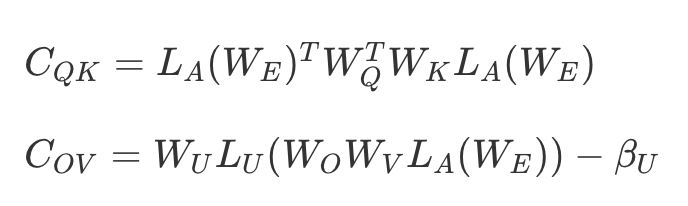

## OV Matrix

In [4]:
task = tasks.tiny_natural_mechanisms("ifelse", "mps")
model: tl.HookedTransformer = task.model

Loaded pretrained model attn-only-1l into HookedTransformer
Moving model to device:  mps


In [5]:
if_token = task.model.tokenizer.encode(" if")[0]
else_token = task.model.tokenizer.encode(" else")[0]

In [6]:
model.blocks[0].ln1(model.W_E).shape

torch.Size([48262, 512])

In [7]:
from transformer_lens.FactoredMatrix import FactoredMatrix
with torch.no_grad():
    C_OV = FactoredMatrix(
        model.unembed.W_U.T.detach().clone(), #N_v, d_model
        model.ln_final((model.OV.AB @ model.blocks[0].ln1(model.W_E).T).transpose(2, 3)).transpose(2, 3) # d_model, N_v
    )
# C_OV = C_OV # accounts for tranpose above (could also just revese the order I think)

In [8]:
C_OV[0, 0].AB

RuntimeError: Invalid buffer size: 8.68 GB

In [ ]:
# output values on else toke 
o_else = C_OV[0, :, else_token, :].AB - model.unembed.b_U[else_token]
o_else.shape

In [ ]:
x = torch.arange(10).reshape(5,2).to(torch.float)
y = torch.softmax(x, dim=0)
y

In [ ]:
y[:, 0].shape

In [ ]:
# so a give src token will output values for each dest token, and if all the other attention heads were ablated and the src got all the attention 
# then the output would be the logits. So it makes sense to the the softmax on the dest tokens
o_else.shape

In [ ]:
# the top tokens that promote else
tok_k_else = (C_OV[0, :, else_token, :].AB - model.unembed.b_U[else_token]).topk(C_OV.shape[-1])

In [ ]:
for tok in tok_k_else.indices[0, :100]:
    print(task.model.tokenizer.decode([tok.item()]))

In [ ]:
tok_k_obama.indices.shape

In [ ]:
# top tokens that promote Obama - yeah this seems off for sure
obama_tokens = task.model.tokenizer.encode(" Obama")
assert len(obama_tokens) == 1
obama_token = obama_tokens[0]
tok_k_obama = (C_OV[0, :, obama_token, :].AB - model.unembed.b_U[obama_token]).topk(C_OV.shape[-1])
for tok in tok_k_obama.indices[0, 0, :100]:
    print(task.model.tokenizer.decode([tok.item()]))


In [ ]:
# TODO: check where Barak is

In [ ]:
for i, ind in enumerate(torch.nonzero(tok_k_else.indices[:, 0, :] == if_token)):
    print(i, 1 - ind[1].item() / C_OV.shape[-1])

In [ ]:
# the top tokens if promotes 
top_k_if = (C_OV[0, :, :, if_token].AB.squeeze(-1) - model.unembed.b_U).topk(C_OV.shape[-1])

In [ ]:
for i, ind in enumerate(torch.nonzero(top_k_if.indices == else_token)):
    print(i, (1 - ind[1] / top_k_if.indices.shape[-1]).item())

looks like for head 0 the if -> else connection is very strong, is hardly present in 1 and 7, and present in varying degrees in the remainder of the attention heads

# QK Matrix

![Screenshot 2024-07-31 at 2.33.10 PM.png](<attachment:Screenshot 2024-07-31 at 2.33.10 PM.png>)
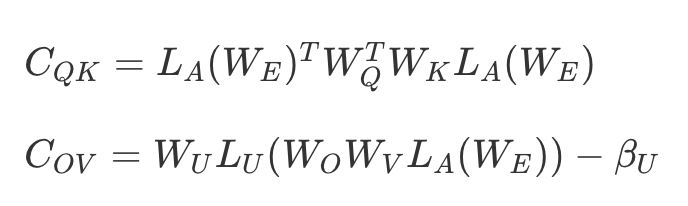

In [ ]:
model.blocks[0].ln1(model.W_E).shape, model.W_K.shape


In [ ]:
(model.blocks[0].ln1(model.W_E) @ model.W_Q).shape

In [ ]:
C_QK = FactoredMatrix(
    model.blocks[0].ln1(model.W_E) @ model.W_Q,
    (model.W_K.transpose(2, 3) @ model.blocks[0].ln1(model.W_E).T) 
)

In [ ]:
C_QK.shape

In [ ]:
# examine [")", "if"] in Q, K